This notebook creates a NN to make predictions based on pre-existing data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
import pandas as pd
import oracledb
from sklearn.model_selection import train_test_split
import tensorflow as tf

from fastai.tabular.all import *

2022-06-27 21:02:17.509138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 21:02:17.509177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
os.environ['PATH']='/home/ubuntu/miniconda3/bin:$PATH'

In [3]:
import yaml
from pathlib import Path
home = str(Path.home())

def process_yaml():
	with open("../config.yaml") as file:
		return yaml.safe_load(file)

class OracleJSONDatabaseThickConnection:
    def __init__(self, data=process_yaml()):
        oracledb.init_oracle_client(lib_dir=data['INSTANT_CLIENT'])
        self.pool = oracledb.create_pool(user=data['db']['username'], password=data['db']['password'], dsn=data['db']['dsn'],
            min=1, max=4, increment=1, getmode=oracledb.POOL_GETMODE_WAIT)
        print('Connection successful.')



    def close_pool(self):
        self.pool.close()
        print('Connection pool closed.')



    def insert(self, collection_name, json_object_to_insert):
        connection = self.pool.acquire()
        connection.autocommit = True
        soda = connection.getSodaDatabase()
        x_collection = soda.createCollection(collection_name)

        try:
            x_collection.insertOne(json_object_to_insert)
            print('[DBG] INSERT {} OK'.format(json_object_to_insert))
        except cx_Oracle.IntegrityError as e:
            print('[DBG] INSERT {} ERR: {} '.format(json_object_to_insert, e))
            return -1
        self.pool.release(connection)
        return 1


    def delete(self, collection_name, on_column, on_value):
        connection = self.pool.acquire()
        connection.autocommit = True
        soda = connection.getSodaDatabase()
        x_collection = soda.createCollection(collection_name)
        qbe = {on_column: on_value}
        x_collection.find().filter(qbe).remove()
        self.pool.release(connection)


    def get_connection(self):
        connection = self.pool.acquire()
        connection.autocommit = True
        return connection


    def close_connection(self, conn_object):
        self.pool.release(conn_object)


    def get_collection_names(self):
        connection = self.pool.acquire()
        connection.autocommit = True
        returning_object = connection.getSodaDatabase().getCollectionNames(startName=None, limit=0)
        self.pool.release(connection)
        return returning_object

    def open_collection(self, collection_name):
        connection = self.pool.acquire()
        returning_object = self.pool.acquire().getSodaDatabase().openCollection(collection_name)
        self.pool.release(connection)
        return returning_object

In [4]:
db = OracleJSONDatabaseThickConnection()
print(db.get_collection_names())

Connection successful.
['1v1_model', 'match', 'match_detail', 'matchups', 'predictor', 'predictor_liveclient', 'summoner']


In [5]:
data = db.open_collection('matchups')
all_data = list()
i = 0
for doc in data.find().getCursor():
    content = doc.getContent()['data']
    all_data.append(content[0])
    all_data.append(content[1])
    i+= 1
    if i>250000:
        break

print('Data length: {}'.format(len(all_data)))

Data length: 500002


In [6]:
df = pd.read_json(json.dumps(all_data), orient='records')

df.head(5)

,goldEarned,totalMinionsKilled,win,kills,assists,deaths,champion,visionScore,puuid,totalDamageDealtToChampions,summonerName
0,14151,212,True,10,4,3,MissFortune,13,BkWXP6tPTxZ6haOZCaX6l_6pJNiaO3x8CJPYWBkgvVhtbZuApJxQpsxy9jsAw33YsXsTHsMnygyXTw,18207,Call me Mytant
1,11835,221,False,7,4,2,Kaisa,28,bI4DqMWR_UVuV3Igo8sw84WMcO-Zc8qXrxiF_9vbRWrZZY71ESePK6OxiNr0VEseTl68h_fMxnFB5A,23786,Seelame
2,6943,40,True,0,14,4,Leona,63,nUUe6Mmrj66Fz5cP8hq5L52w0PAUbRWhG8pxEsX-7Fq4zAXFOuM5ouC9reQDnbwq0iCfQHcXFIf6Nw,4849,robloxmaciek
3,5575,25,False,1,4,5,Soraka,40,ZPqHuoSerAj4hROC5XjnI8DQs9dIQZZ157YzVHyfc3ONXZaeYBEwCL97x-olmleOQZR3B7Gxd7HmdA,3410,ACE Zero Kara
4,10909,23,True,5,8,5,Kindred,27,0DRBo86SL9xj2XwKJ9nUwXP8SQQ9XTWpve-fhkwfXVndyexTjfWB0lDGBp-Gv2XZiX_fbpduChD4kg,13106,Viego is bait


In [7]:
df.columns

Index(['goldEarned', 'totalMinionsKilled', 'win', 'kills', 'assists', 'deaths',
       'champion', 'visionScore', 'puuid', 'totalDamageDealtToChampions',
       'summonerName'],
      dtype='object')

In [8]:
df.drop(columns=['puuid', 'summonerName'], inplace=True)

In [9]:
df.describe()

,goldEarned,totalMinionsKilled,kills,assists,deaths,visionScore,totalDamageDealtToChampions
count,500002.000000,500002.000000,500002.000000,500002.000000,500002.000000,500002.000000,5.000020e+05
mean,10276.589608,111.021350,5.439304,7.865587,5.448406,26.296585,1.139089e+04
std,3597.592889,77.027321,4.434037,5.682013,3.056722,19.228679,3.037033e+06
min,664.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.147484e+09
25%,7707.000000,32.000000,2.000000,4.000000,3.000000,14.000000,8.332000e+03
50%,9998.000000,123.000000,4.000000,7.000000,5.000000,21.000000,1.371300e+04
75%,12578.000000,173.000000,8.000000,11.000000,7.000000,32.000000,2.083700e+04
max,30171.000000,483.000000,48.000000,52.000000,26.000000,214.000000,1.083850e+05


In [10]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df)) # 80-20 split

dls = TabularDataLoaders.from_df(df=df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = 'champion',
                   cont_names = ['goldEarned', 'totalMinionsKilled',
                                'kills', 'assists', 'deaths', 'visionScore', 'totalDamageDealtToChampions'],
                    y_names = 'win',
                    y_block = CategoryBlock(),
                    splits=splits,
                    bs=64)

In [11]:
df.iloc[:5]

,goldEarned,totalMinionsKilled,win,kills,assists,deaths,champion,visionScore,totalDamageDealtToChampions
0,14151,212,True,10,4,3,MissFortune,13,18207
1,11835,221,False,7,4,2,Kaisa,28,23786
2,6943,40,True,0,14,4,Leona,63,4849
3,5575,25,False,1,4,5,Soraka,40,3410
4,10909,23,True,5,8,5,Kindred,27,13106


In [12]:
#dls.show_batch(max_n=10, show=True, unique=True)
dls.show_batch()

,champion,goldEarned,totalMinionsKilled,kills,assists,deaths,visionScore,totalDamageDealtToChampions,win
0,Leblanc,6179.000161,138.000000,1.000000e+00,5.455708e-08,1.0,10.0,9324.999986,False
1,MonkeyKing,7907.999910,175.000000,2.095798e-07,2.000000e+00,4.0,10.0,8526.999910,False
2,TahmKench,9735.999984,157.000000,2.095798e-07,6.000000e+00,6.0,13.0,12846.000094,False
3,Kalista,5768.999921,112.000000,1.000000e+00,4.000000e+00,6.0,10.0,4902.999859,False
4,Diana,8665.999966,12.000003,6.000000e+00,8.000000e+00,2.0,13.0,9453.999982,True
5,Caitlyn,6161.999798,106.000000,3.000000e+00,4.000000e+00,6.0,7.0,6157.999858,False
6,Hecarim,13542.000049,29.999999,8.000000e+00,1.300000e+01,7.0,31.0,18056.999988,False
7,Caitlyn,15368.000030,231.000000,8.000000e+00,8.000000e+00,7.0,36.0,16734.999895,True
8,Sejuani,12711.999960,152.000001,1.000000e+00,2.800000e+01,9.0,35.0,24750.000219,True
9,Sylas,9635.999987,128.999999,9.000000e+00,5.455708e-08,7.0,13.0,16453.000003,False


In [13]:
learn = tabular_learner(dls, metrics=[accuracy])

SuggestedLRs(valley=0.0014454397605732083)

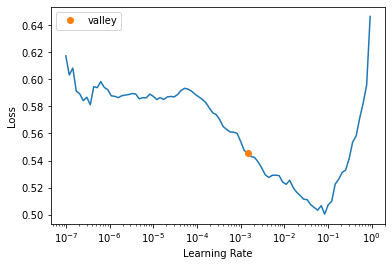

In [14]:
learn.lr_find()

In [15]:
#learn.fit_one_cycle(150) #.fit(150, lr=1e-3)
learn.fit(150, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.367738,0.360234,0.833890,00:51
1,0.373200,0.361195,0.834080,00:46
2,0.358821,0.361820,0.834330,00:46
3,0.375638,0.358868,0.836670,00:48
4,0.367089,0.355612,0.836930,00:57
5,0.372845,0.359201,0.835360,01:19
6,0.359382,0.359331,0.835410,01:13
7,0.363661,0.358722,0.836620,01:18
8,0.355863,0.357498,0.836190,01:15
9,0.354799,0.357357,0.834920,01:16


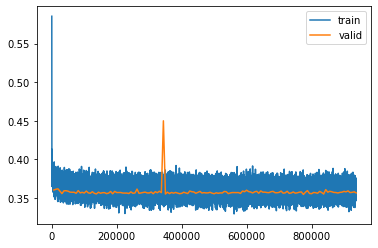

In [17]:
learn.recorder.plot_loss()

In [18]:
learn.show_results()

,champion,goldEarned,totalMinionsKilled,kills,assists,deaths,visionScore,totalDamageDealtToChampions,win,win_pred
0,1.0,1.750278,1.584319,0.579026,0.903327,1.161950,0.297124,0.008498,0.0,0.0
1,126.0,-1.469312,-1.051589,-1.002396,-1.031999,-0.474134,0.245113,-0.001833,0.0,0.0
2,132.0,-0.272916,-1.220391,-0.776479,0.727389,-0.474134,-0.691087,-0.000763,1.0,1.0
3,23.0,0.265768,-1.012635,0.804943,-0.680122,-1.128568,-0.795109,0.001668,1.0,1.0
4,65.0,-1.818609,-1.350239,-1.228313,-1.383877,0.507517,-0.691087,-0.002193,0.0,0.0
5,39.0,-0.045707,0.948065,-0.098727,-1.031999,-0.146917,-0.118965,0.000445,0.0,0.0
6,58.0,0.371447,-0.713985,0.579026,-0.328244,0.834733,-0.118965,0.003365,0.0,0.0
7,49.0,1.102856,0.688370,0.579026,1.431144,0.834733,0.453157,0.004040,0.0,1.0
8,18.0,0.749388,1.194776,0.127191,-0.328244,0.180300,0.089079,0.004046,0.0,0.0


In [19]:
row, clas, probs = learn.predict(df.iloc[0])

In [26]:
print('Winning probability: {}%, losing probability: {}%'.format(probs[0].item(), probs[1].item()))

Winning probability: 0.10949157923460007%, losing probability: 0.8905084133148193%


In [32]:
ds_aggregator = list()

for x in range(10):
    row, clas, probs = learn.predict(df.iloc[x])
    del row, clas
    ds_aggregator.append(probs[0].item()) # aggregate winning probabilities

import statistics
result = statistics.mean(ds_aggregator)

print('Combined weighted winning probability: {}'.format(result))

Combined weighted winning probability: 0.5499033994972706
